In [1]:
# ### mount on google drive
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir("/content/drive/My Drive/WatNet/notebooks")
# !pip install rasterio

In [2]:
import os
os.chdir('..')
import glob
import time
import random
import numpy as np
import tensorflow as tf
from notebooks import config
import matplotlib.pyplot as plt
from dataloader.tfrecord_io import parse_image,parse_shape,toPatchPair
from dataloader.img_aug import img_aug
from utils.acc_eval import acc_patch
from utils.imgShow import imgShow, imsShow
from models.seg_model.watnet import watnet


## Data loading
### _Load and parse the tfrecord data_

In [3]:
### data loading from .tfrecord file
path_tra_data = 'data/tfrecord-s2/tra_data.tfrecords'
path_val_data = 'data/tfrecord-s2/val_data.tfrecords'
## training data
tra_dset = tf.data.TFRecordDataset(path_tra_data)
tra_dset = tra_dset.map(parse_image).map(parse_shape)\
            .cache()\
            .map(toPatchPair)\
            .map(img_aug)
tra_dset = tra_dset.shuffle(config.buffer_size).batch(config.batch_size)

## validation data
val_dset = tf.data.TFRecordDataset(path_val_data)
val_dset = val_dset.map(parse_image).map(parse_shape)\
            .map(toPatchPair)
val_dset = val_dset.batch(32)


In [4]:
# # for i in range(5):
# start = time.time()
# i = 1
# for patch, truth in val_dset.take(1):
#     i+=1
# imsShow(img_list=[patch[0], truth[0]], 
#     img_name_list=['patch', 'truth'],
#     clip_list=[2,0]
#     )
# plt.show()
# print('num:', i)
# print('time:', time.time()-start)


In [5]:
## model configuration
model = watnet(input_shape=(config.patch_size, config.patch_size, config.num_bands), nclasses=2)



*** Building DeepLabv3Plus Network ***
*** Output_Shape => (None, 512, 512, 1) ***


In [6]:
'''------1. train step------'''
@tf.function
def train_step(model, loss_fun, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=True)
        loss = loss_fun(y, y_pre)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    config.tra_loss.update_state(loss)
    config.tra_oa.update_state(y, y_pre)
    config.tra_miou.update_state(y, y_pre)
    return config.tra_loss.result(), config.tra_oa.result(), config.tra_miou.result()

'''------2. test step------'''
@tf.function
def test_step(model, loss_fun, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=False)
        loss = loss_fun(y, y_pre)
    config.val_loss.update_state(loss) 
    config.val_oa.update_state(y, y_pre)
    config.val_miou.update_state(y, y_pre)
    return config.val_loss.result(), config.val_oa.result(), config.val_miou.result()

'''------3. train loops------'''
def train_loops(model, loss_fun, optimizer, tra_dset, val_dset, epochs):
    max_miou_pre = 0.8
    for epoch in range(epochs):
        start = time.time()
        ###--- train the model ---
        for x_batch, y_batch in tra_dset:
            tra_loss_epoch,tra_oa_epoch,tra_miou_epoch = train_step(model, loss_fun, optimizer, x_batch, y_batch)        
        ### --- test the model ---
        for x_batch, y_batch in val_dset:
            val_loss_epoch, val_oa_epoch, val_miou_epoch = test_step(model, loss_fun, x_batch, y_batch)
        ### --- update the metrics ---
        config.tra_loss.reset_states(), config.tra_oa.reset_states(), config.tra_miou.reset_states()
        config.val_loss.reset_states(), config.val_oa.reset_states(), config.val_miou.reset_states()
        format = 'Ep {}: traLoss:{:.3f},traOA:{:.3f},traMIoU:{:.3f},valLoss:{:.3f},valOA:{:.3f},valMIoU:{:.3f},time:{:.0f}s'
        print(format.format(epoch + 1, tra_loss_epoch, tra_oa_epoch, tra_miou_epoch, val_loss_epoch, val_oa_epoch, val_miou_epoch, time.time() - start))

        ## --- visualize the results ---
        if epoch%20 == 0:
            i = np.random.randint(config.batch_size)
            for val_patch, val_truth in val_dset.take(1):
                plt.figure(figsize=(8,4))
                imsShow(img_list=[val_patch.numpy()[i], val_truth.numpy()[i]], \
                        img_name_list=['val_patch', 'val_truth'], \
                        clip_list=[2,0],\
                        color_bands_list=None)
                plt.show()


Ep 1: traLoss:0.402,traOA:0.84,traMIoU:0.66,valLoss:3.031,valOA:0.23,valMIoU:0.12,time:18s


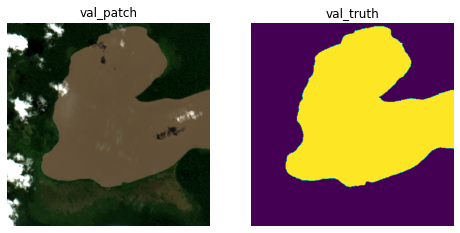

Ep 2: traLoss:0.183,traOA:0.93,traMIoU:0.84,valLoss:1.372,valOA:0.77,valMIoU:0.39,time:8s
Ep 3: traLoss:0.165,traOA:0.94,traMIoU:0.86,valLoss:1.139,valOA:0.77,valMIoU:0.39,time:8s
Ep 4: traLoss:0.138,traOA:0.95,traMIoU:0.88,valLoss:1.137,valOA:0.77,valMIoU:0.39,time:8s
Ep 5: traLoss:0.177,traOA:0.93,traMIoU:0.84,valLoss:0.588,valOA:0.77,valMIoU:0.39,time:8s
Ep 6: traLoss:0.215,traOA:0.92,traMIoU:0.82,valLoss:0.919,valOA:0.77,valMIoU:0.39,time:8s
Ep 7: traLoss:0.176,traOA:0.93,traMIoU:0.85,valLoss:0.831,valOA:0.77,valMIoU:0.39,time:8s
Ep 8: traLoss:0.150,traOA:0.94,traMIoU:0.86,valLoss:0.918,valOA:0.77,valMIoU:0.39,time:8s
Ep 9: traLoss:0.142,traOA:0.95,traMIoU:0.87,valLoss:1.104,valOA:0.77,valMIoU:0.39,time:8s
Ep 10: traLoss:0.149,traOA:0.94,traMIoU:0.86,valLoss:0.996,valOA:0.77,valMIoU:0.39,time:8s
Ep 11: traLoss:0.163,traOA:0.94,traMIoU:0.86,valLoss:0.946,valOA:0.77,valMIoU:0.39,time:8s
Ep 12: traLoss:0.173,traOA:0.93,traMIoU:0.84,valLoss:1.010,valOA:0.77,valMIoU:0.39,time:8s
Ep 13: 

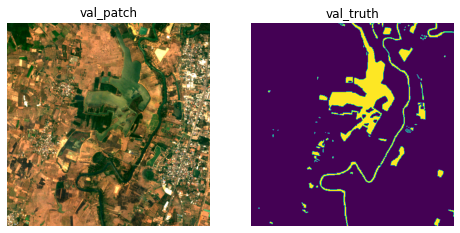

Ep 22: traLoss:0.105,traOA:0.96,traMIoU:0.90,valLoss:0.123,valOA:0.97,valMIoU:0.92,time:8s
Ep 23: traLoss:0.116,traOA:0.96,traMIoU:0.89,valLoss:0.113,valOA:0.98,valMIoU:0.93,time:8s
Ep 24: traLoss:0.148,traOA:0.95,traMIoU:0.87,valLoss:0.217,valOA:0.86,valMIoU:0.63,time:8s
Ep 25: traLoss:0.123,traOA:0.96,traMIoU:0.91,valLoss:0.100,valOA:0.97,valMIoU:0.91,time:9s
Ep 26: traLoss:0.107,traOA:0.96,traMIoU:0.90,valLoss:0.083,valOA:0.97,valMIoU:0.92,time:8s
Ep 27: traLoss:0.115,traOA:0.96,traMIoU:0.89,valLoss:0.103,valOA:0.97,valMIoU:0.92,time:8s
Ep 28: traLoss:0.150,traOA:0.94,traMIoU:0.86,valLoss:0.097,valOA:0.97,valMIoU:0.92,time:8s
Ep 29: traLoss:0.131,traOA:0.96,traMIoU:0.89,valLoss:0.118,valOA:0.98,valMIoU:0.93,time:8s
Ep 30: traLoss:0.122,traOA:0.96,traMIoU:0.90,valLoss:0.078,valOA:0.98,valMIoU:0.94,time:8s
Ep 31: traLoss:0.175,traOA:0.93,traMIoU:0.84,valLoss:0.078,valOA:0.98,valMIoU:0.94,time:8s
Ep 32: traLoss:0.136,traOA:0.95,traMIoU:0.88,valLoss:0.061,valOA:0.98,valMIoU:0.95,time:9s

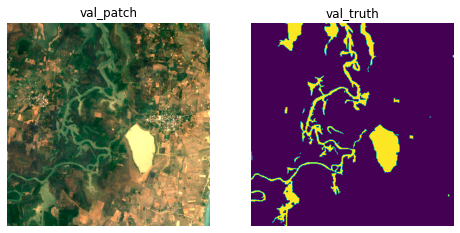

Ep 42: traLoss:0.091,traOA:0.97,traMIoU:0.91,valLoss:0.058,valOA:0.98,valMIoU:0.95,time:8s
Ep 43: traLoss:0.128,traOA:0.96,traMIoU:0.89,valLoss:0.133,valOA:0.96,valMIoU:0.89,time:8s
Ep 44: traLoss:0.122,traOA:0.95,traMIoU:0.89,valLoss:0.065,valOA:0.98,valMIoU:0.95,time:8s
Ep 45: traLoss:0.095,traOA:0.97,traMIoU:0.91,valLoss:0.386,valOA:0.86,valMIoU:0.63,time:8s
Ep 46: traLoss:0.093,traOA:0.96,traMIoU:0.90,valLoss:0.084,valOA:0.98,valMIoU:0.94,time:8s
Ep 47: traLoss:0.099,traOA:0.96,traMIoU:0.90,valLoss:0.060,valOA:0.98,valMIoU:0.95,time:8s
Ep 48: traLoss:0.114,traOA:0.96,traMIoU:0.89,valLoss:0.086,valOA:0.97,valMIoU:0.93,time:8s
Ep 49: traLoss:0.126,traOA:0.95,traMIoU:0.88,valLoss:0.066,valOA:0.98,valMIoU:0.94,time:8s
Ep 50: traLoss:0.116,traOA:0.96,traMIoU:0.89,valLoss:0.049,valOA:0.98,valMIoU:0.95,time:8s
Ep 51: traLoss:0.113,traOA:0.96,traMIoU:0.89,valLoss:0.125,valOA:0.95,valMIoU:0.87,time:8s
Ep 52: traLoss:0.108,traOA:0.96,traMIoU:0.91,valLoss:0.061,valOA:0.98,valMIoU:0.95,time:8s

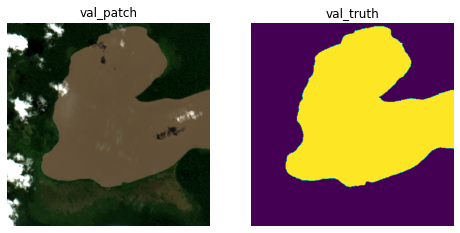

Ep 62: traLoss:0.103,traOA:0.96,traMIoU:0.90,valLoss:0.048,valOA:0.98,valMIoU:0.95,time:8s
Ep 63: traLoss:0.093,traOA:0.97,traMIoU:0.92,valLoss:0.060,valOA:0.98,valMIoU:0.94,time:8s
Ep 64: traLoss:0.090,traOA:0.97,traMIoU:0.92,valLoss:0.063,valOA:0.98,valMIoU:0.94,time:8s
Ep 65: traLoss:0.085,traOA:0.97,traMIoU:0.92,valLoss:0.054,valOA:0.98,valMIoU:0.95,time:8s
Ep 66: traLoss:0.063,traOA:0.98,traMIoU:0.93,valLoss:0.060,valOA:0.98,valMIoU:0.94,time:8s
Ep 67: traLoss:0.091,traOA:0.96,traMIoU:0.91,valLoss:0.059,valOA:0.98,valMIoU:0.94,time:8s
Ep 68: traLoss:0.087,traOA:0.97,traMIoU:0.92,valLoss:0.057,valOA:0.98,valMIoU:0.94,time:8s
Ep 69: traLoss:0.086,traOA:0.97,traMIoU:0.92,valLoss:0.075,valOA:0.97,valMIoU:0.92,time:8s
Ep 70: traLoss:0.083,traOA:0.97,traMIoU:0.93,valLoss:0.056,valOA:0.98,valMIoU:0.94,time:8s
Ep 71: traLoss:0.104,traOA:0.97,traMIoU:0.91,valLoss:0.059,valOA:0.98,valMIoU:0.95,time:8s
Ep 72: traLoss:0.075,traOA:0.97,traMIoU:0.93,valLoss:0.050,valOA:0.98,valMIoU:0.95,time:8s

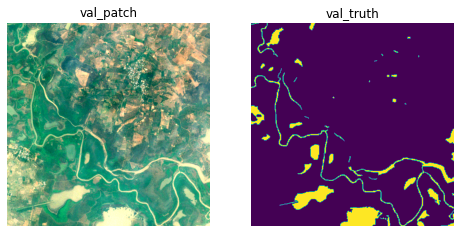

Ep 82: traLoss:0.098,traOA:0.96,traMIoU:0.90,valLoss:0.081,valOA:0.97,valMIoU:0.93,time:8s
Ep 83: traLoss:0.125,traOA:0.95,traMIoU:0.87,valLoss:0.075,valOA:0.97,valMIoU:0.92,time:8s
Ep 84: traLoss:0.115,traOA:0.96,traMIoU:0.91,valLoss:0.073,valOA:0.98,valMIoU:0.94,time:8s
Ep 85: traLoss:0.095,traOA:0.97,traMIoU:0.92,valLoss:0.064,valOA:0.98,valMIoU:0.94,time:8s
Ep 86: traLoss:0.086,traOA:0.97,traMIoU:0.91,valLoss:0.059,valOA:0.98,valMIoU:0.94,time:8s
Ep 87: traLoss:0.105,traOA:0.96,traMIoU:0.90,valLoss:0.055,valOA:0.98,valMIoU:0.94,time:8s
Ep 88: traLoss:0.086,traOA:0.97,traMIoU:0.93,valLoss:0.049,valOA:0.98,valMIoU:0.95,time:9s
Ep 89: traLoss:0.089,traOA:0.96,traMIoU:0.91,valLoss:0.052,valOA:0.98,valMIoU:0.95,time:8s
Ep 90: traLoss:0.082,traOA:0.97,traMIoU:0.92,valLoss:0.050,valOA:0.98,valMIoU:0.95,time:8s
Ep 91: traLoss:0.082,traOA:0.97,traMIoU:0.92,valLoss:0.060,valOA:0.98,valMIoU:0.94,time:8s
Ep 92: traLoss:0.109,traOA:0.96,traMIoU:0.90,valLoss:0.072,valOA:0.97,valMIoU:0.92,time:8s

In [7]:
## training
train_loops(model=model, \
            loss_fun=config.loss_bce, \
            optimizer=config.opt_adam, \
            tra_dset=tra_dset, \
            val_dset=val_dset, \
            epochs=config.epochs)


In [8]:
### model saving
# path_save = 'models/pretrained_model/watnet_tmp'
# model.save(path_save)

